<a href="https://colab.research.google.com/github/dsgayda/ecs-271-final-project/blob/main/lstm_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
!pip install tensorflow
# ==2.5.0

     |████████████████████████████████| 462 kB 5.2 MB/s 


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: /content/Sunspots.csv
100% 70.8k/70.8k [00:00<00:00, 72.4MB/s]


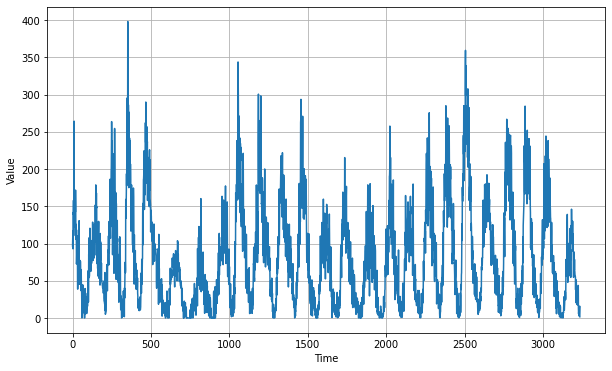

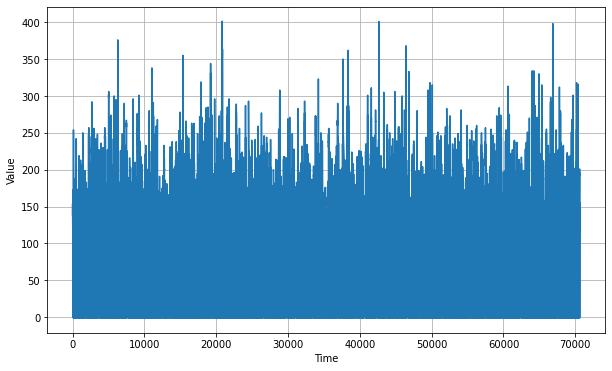

In [41]:
import csv
import pandas as pd
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)


time_step = []
glucose_level = []

with open('./cleaned_id_95_dataset.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    glucose_level.append(float(row[3]))
    time_step.append(int(row[0]))


# with open('./nans_cleaned_id_95_dataset.csv') as csvfile:
#   reader = csv.reader(csvfile, delimiter=',')
#   next(reader)
#   for row in reader:
#     glucose_level.append(float(row[3]))
#     time_step.append(int(row[0]))

series = np.array(glucose_level)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

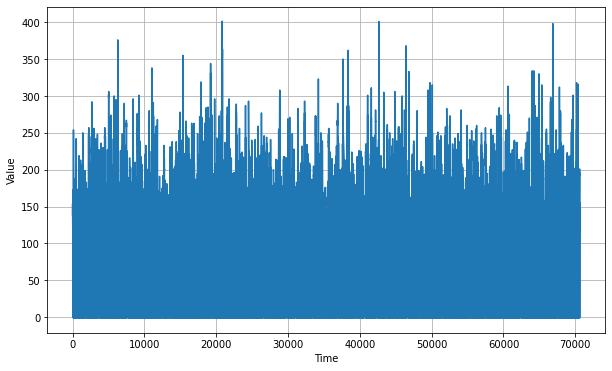

In [ ]:
# series = np.array(sunspots)
# time = np.array(time_step)
# plt.figure(figsize=(10, 6))
# plot_series(time, series)

series = np.array(glucose_level)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(3000,)
Epoch 1/100
12/12 [==============================] - 13s 28ms/step - loss: 114.6453 - mae: 115.1453 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 0s 28ms/step - loss: 111.9761 - mae: 112.4760 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 1s 29ms/step - loss: 108.1816 - mae: 108.6816 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 0s 30ms/step - loss: 103.7988 - mae: 104.2988 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 0s 29ms/step - loss: 98.9003 - mae: 99.4003 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 1s 28ms/step - loss: 93.4557 - mae: 93.9557 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 0s 27ms/step - loss: 87.4166 - mae: 87.9165 - lr: 1.9953e-08
Epoch 8/100
12/12 [======

(1e-08, 0.0001, 0.0, 60.0)

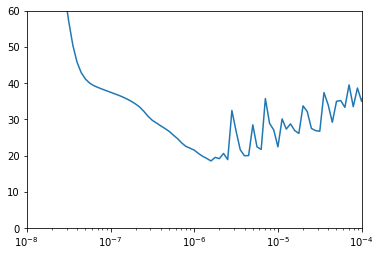

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 4s 17ms/step - loss: 45.8601 - mae: 46.3576
Epoch 2/500
30/30 [==============================] - 1s 17ms/step - loss: 33.6208 - mae: 34.1172
Epoch 3/500
30/30 [==============================] - 1s 16ms/step - loss: 28.0108 - mae: 28.5063
Epoch 4/500
30/30 [==============================] - 1s 16ms/step - loss: 26.4592 - mae: 26.9546
Epoch 5/500
30/30 [==============================] - 1s 17ms/step - loss: 25.0076 - mae: 25.5027
Epoch 6/500
30/30 [==============================] - 1s 17ms/step - loss: 27.8782 - mae: 28.3740
Epoch 7/500
30/30 [==============================] - 1s 16ms/step - loss: 23.4040 - mae: 23.8986
Epoch 8/500
30/30 [==============================] - 1s 17ms/step - loss: 29.1572 - mae: 29.6528
Epoch 9/500
30/30 [==============================] - 1s 16ms/step - loss: 23.9201 - mae: 24.4147
Epoch 10/500
30/30 [==============================] - 1s 16ms/step - loss: 25.4806 - mae: 25.9759
Epoch 11/500
30/30 [=========

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

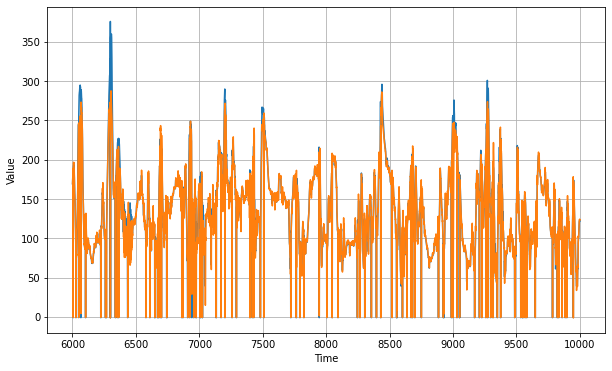

In [42]:
split_time2 = 1000
# # time_train = time[:split_time]
# # x_train = series[:split_time]
time_valid2 = time[split_time:]
x_valid2 = series[split_time:]
# # rnn_forecast2 = model_forecast(model, series[..., np.newaxis], window_size)
# rnn_forecast2 = rnn_forecast[split_time2 - window_size:-1, -1, 0]

# window_size = 30
# batch_size = 32
# shuffle_buffer_size = 1000

plt.figure(figsize=(10, 6))
plot_series(time_valid2[3000:7000], x_valid2[3000:7000])
plot_series(time_valid2[3000:7000], rnn_forecast[3000:7000])

# plt.figure(figsize=(10, 6))
# plot_series(time_valid, x_valid)
# plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

8.7482815

<Figure size 432x288 with 0 Axes>

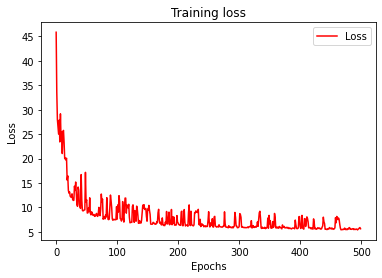

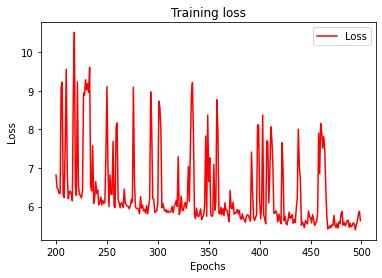

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)

[209.08575 204.75514 198.75266 ... 137.44504 138.96889 144.32787]
